## Running a bell circuit on different backends

In [1]:
import numpy as np
import time

from braket.circuits import Circuit
from braket.devices import LocalSimulator
from qiskit_braket_provider import AWSBraketProvider
from qiskit_braket_provider.providers import adapter
from braket.aws import AwsSession

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BackendEstimator, Estimator
from qiskit.quantum_info.operators import SparsePauliOp
from qiskit.primitives import BackendEstimator
from qiskit.circuit import ParameterVector, Parameter

import sys
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
module_path = os.path.abspath(os.path.join('/Users/lukasvoss/Documents/Master Wirtschaftsphysik/Masterarbeit Yale-NUS CQT/Quantum_Optimal_Control'))
if module_path not in sys.path:
    sys.path.append(module_path)

from braket_estimator import BraketEstimator

aws_session = AwsSession(default_bucket="amazon-braket-us-west-1-lukasvoss")
AWSBraketProvider().backends()

[BraketBackend[Aria 1],
 BraketBackend[Aria 2],
 BraketBackend[Aspen-M-3],
 BraketBackend[Forte 1],
 BraketBackend[Harmony],
 BraketBackend[Lucy],
 BraketBackend[SV1],
 BraketBackend[dm1]]

In [2]:
batchsize = 50
n_shots = 10_000

#### Run with native Braket SV Backend

In [3]:
backend = AWSBraketProvider().get_backend('SV1')

device = backend._device
device

Device('name': SV1, 'arn': arn:aws:braket:::device/quantum-simulator/amazon/sv1)

In [4]:
braket_bell_circ = Circuit().h(0).cnot(0, 1)
print(braket_bell_circ)

T  : |0|1|
          
q0 : -H-C-
        | 
q1 : ---X-

T  : |0|1|


In [5]:
start_time = time.time()
job_braket_native = device.run_batch(
    [braket_bell_circ] * batchsize,
    shots=n_shots,
)
run_batch_time = time.time() - start_time
print('--- {} seconds ---'.format(round(run_batch_time, 2)))
print('Execution time per circuit:', round(run_batch_time / batchsize, 2), 'seconds')

--- 20.55 seconds ---
Execution time per circuit: 0.41 seconds


#### Run with Braket Provider + **Estimator Primitive**

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


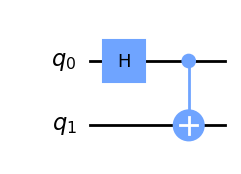

In [6]:
qiskit_bell_circ = QuantumCircuit(2)
qiskit_bell_circ.h(0)
qiskit_bell_circ.cx(0, 1)

qiskit_bell_circ.draw("mpl")

In [7]:
backend = AWSBraketProvider().get_backend('SV1')
estimator = BackendEstimator(backend)
qiskit_observables = SparsePauliOp.from_list(([('XX', 0.25), ("IZ", 0.25), ("ZZ", 0.25), ("XY", 0.25)]))

qiskit_start_time = time.time()
job = estimator.run(
    circuits=[qiskit_bell_circ] * batchsize,
    observables=[qiskit_observables] * batchsize,
    shots=n_shots
)
job.result().values # This is the time-consuming line

qiskit_run_batch_time = time.time() - qiskit_start_time
print('--- {} seconds ---'.format(round(qiskit_run_batch_time, 2)))
print('Execution time per circuit:', round(qiskit_run_batch_time / (batchsize * 3), 2), 'seconds')

/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:475: UserWarning: Device does not support global phase; global phase of 1.5707963267948966 will not be included in Braket circuit
  warnings.warn(
/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:475: UserWarning: Device does not support global phase; global phase of 2.3561944901923457 will not be included in Braket circuit
  warnings.warn(
/Users/lukasvoss/anaconda3/envs/braket/lib/python3.10/site-packages/qiskit_braket_provider/providers/adapter.py:475: UserWarning: Device does not support global phase; global phase of 4.71238898038469 will not be included in Braket circuit
  warnings.warn(


--- 532.19 seconds ---
Execution time per circuit: 3.55 seconds


In [8]:
qiskit_expvals = job.result().values

#### Use ``Estimator`` from Qiskit

In [9]:
start_time = time.time()
job = Estimator().run(
    circuits=[qiskit_bell_circ] * batchsize,
    observables=[qiskit_observables] * batchsize,
    shots=n_shots
)
qiskit_expvals_2 = job.result().values
run_batch_time = time.time() - start_time
print('--- {} seconds ---'.format(round(run_batch_time, 2)))
# Three non-commuting parts of the Hamiltonian lead to three measured circuits per Hamiltonian
print('Execution time per circuit:', round(run_batch_time / (batchsize * 3), 2), 'seconds')

--- 0.03 seconds ---
Execution time per circuit: 0.0 seconds


In [10]:
qiskit_expvals_2 - qiskit_expvals

array([ 6.52172572e-03,  3.83237390e-03, -1.62286450e-03,  9.47406549e-04,
        1.83805715e-03, -2.22005447e-03,  5.09787944e-04,  4.26404024e-03,
       -1.30624872e-02, -3.76401220e-03,  3.98180743e-03, -6.86605655e-03,
        3.15456228e-04,  4.24350792e-03, -1.00592355e-02,  5.12491343e-03,
        4.23377748e-03, -7.85588614e-04,  1.72508567e-03,  5.40765830e-03,
       -8.90928180e-03,  9.60162955e-03, -2.73829519e-03,  1.44551724e-03,
       -6.11207762e-03,  3.28336467e-03, -1.13255682e-02, -4.77302594e-03,
       -8.66600981e-04,  3.76851593e-03, -6.93117928e-03, -4.69270078e-03,
        1.59332919e-03,  1.87959124e-03, -5.31490311e-03,  5.46539599e-03,
       -3.08538068e-03,  2.52050242e-03, -7.61808657e-04,  4.58804897e-04,
        1.93284996e-04,  1.34225239e-03,  2.95132323e-03,  1.00699262e-02,
       -1.53147434e-03,  1.15623156e-03, -3.63136131e-03, -2.00322917e-05,
       -7.08398019e-03,  1.03304268e-02])

In [11]:
max(qiskit_expvals_2 - qiskit_expvals)

0.0103304268078932

#### Run Circuit and Measure observables on own ``BraketEstimator``

In [12]:
backend = LocalSimulator()
estimator = BraketEstimator(backend)

braket_observables = qiskit_observables.to_list()

In [13]:
start_time = time.time()
expvals = estimator.run(
    circuit=[braket_bell_circ] * batchsize,
    observables=[braket_observables] * batchsize,
    target_register=[[0, 1]] * batchsize,
    shots=n_shots
)
run_braket_estimator_time = time.time() - start_time
print('--- {} seconds ---'.format(round(run_braket_estimator_time, 2)))
print('Execution time per circuit:', round(run_braket_estimator_time / (batchsize * 3), 2), 'seconds')

--- 4.97 seconds ---
Execution time per circuit: 0.03 seconds


In [14]:
expvals.astype(float) - qiskit_expvals

/var/folders/6b/76tj41f506g7_0dg_k15w_d80000gn/T/ipykernel_22368/798129361.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  expvals.astype(float) - qiskit_expvals


array([ 9.450e-03,  1.200e-03,  9.800e-03,  4.800e-03, -8.500e-04,
        2.450e-03,  3.250e-03,  3.300e-03, -7.000e-03, -5.000e-05,
        7.250e-03,  8.000e-04,  3.400e-03,  2.050e-03, -8.150e-03,
        6.000e-04,  3.750e-03,  3.400e-03, -2.300e-03,  1.600e-03,
       -4.800e-03,  6.500e-03,  1.150e-03,  1.100e-03, -5.850e-03,
       -5.500e-04,  3.000e-04, -5.000e-04,  4.800e-03,  2.200e-03,
       -5.600e-03, -3.250e-03, -3.500e-04, -6.000e-04, -6.000e-04,
        4.800e-03, -6.200e-03, -2.850e-03,  2.350e-03,  1.135e-02,
        3.550e-03,  1.300e-03, -3.400e-03,  6.450e-03,  1.340e-02,
        3.050e-03, -1.050e-03,  2.950e-03, -9.300e-03,  8.300e-03])

In [15]:
max(expvals.astype(float) - qiskit_expvals)

/var/folders/6b/76tj41f506g7_0dg_k15w_d80000gn/T/ipykernel_22368/3208180139.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  max(expvals.astype(float) - qiskit_expvals)


0.013400000000000079

#### Running batch of qiskit circuits with SV1 backend provider

In [16]:
backend = AWSBraketProvider().get_backend('SV1')

In [17]:
qiskit_start_time = time.time()
job = backend.run(
    [qiskit_bell_circ] * batchsize,
    shots=n_shots
)
result = job.result() # This is the time-consuming line

qiskit_run_batch_time = time.time() - qiskit_start_time
print('--- {} seconds ---'.format(round(qiskit_run_batch_time, 2)))
print('Execution time per batch:', round(qiskit_run_batch_time / batchsize, 2), 'seconds')

--- 156.75 seconds ---
Execution time per batch: 3.13 seconds
